# Problem Statement: **Optimization of AtliQ's Fashion Image Classifier**

### AtliQ Retail wants to develop a neural network model to classify fashion items from the **FashionMNIST** dataset. Your task is to optimize the model's performance by experimenting with different optimization algorithms.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt

# Check if CUDA (GPU) is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")



---



**Step1**: Load and Sample the Dataset

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_subset_size = 12000
test_subset_size = 3000

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.8MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 202kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.76MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 16.6MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw





---



**Step2**: Create Dataloaders

* batch size = 32

In [ ]:
train_subset, _ = random_split(train_dataset, [train_subset_size, len(train_dataset) - train_subset_size])
test_subset, _ = random_split(test_dataset, [test_subset_size, len(test_dataset) - test_subset_size])

In [ ]:
batch_size = 32
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

torch.Size([32, 1, 28, 28]) torch.Size([32])


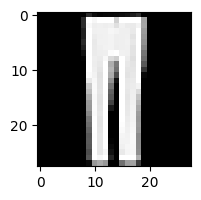

In [ ]:
# Check a sample image in FashionMNIST Dataset

for images, labels in train_loader:
    print(images.shape, labels.shape)
    break

plt.figure(figsize=(2,2))
plt.imshow(images[7].cpu().squeeze(), cmap='gray')
plt.show()



---



**Step3**: Define the Neural Network

* Create a fully connected feed-forward neural network (no CNN).

Structure:
* Input layer: 784 neurons (28x28 image flattened).
* 1st hidden layer: 128 neurons with ReLU activation.
* 2nd hidden layer: 64 neurons with ReLU activation.
* Output layer: 10 neurons (one for each class) with Softmax activation.
* Use `CrossEntropyLoss()` as Loss function

Use `nn.Sequential`

In [ ]:
class FashionNN(nn.Module):
    def __init__(self):
        super(FashionNN, self).__init__()
        self.network = nn.Sequential(
            nn.Flatten(),          # Flatten the input tensor
            nn.Linear(28*28, 128), # Input layer (784)
            nn.ReLU(),             # Activation
            nn.Linear(128, 64),    # Hidden layer 1
            nn.ReLU(),             # Activation
            nn.Linear(64, 10),     # Output layer (10 classes)
            nn.Softmax(dim=1)      # Softmax for probabilities
        )

    def forward(self, x):
        return self.network(x)

model = FashionNN()
print(model)

loss_fn = nn.CrossEntropyLoss()

FashionNN(
  (network): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
    (5): Softmax(dim=1)
  )
)




---



**Step4**: Train and Evaluate with SGD

* set number of epochs to 10
* `lr` = 0.01
* momentum = 0.0





In [ ]:
# Set number of epochs
num_epochs = 10

# Initialize the optimizer
optimizer_sgd = optim.SGD(model.parameters(), lr=0.01, momentum=0.0)

# Store loss for each epoch
epoch_losses = []

# Train the model for num_epochs
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        optimizer_sgd.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer_sgd.step()

        running_loss += loss.item()

    # Calculate average loss for the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# Step 2: Calculate accuracy after all epochs
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy with SGD optimizer: {accuracy:.2f}%")


Epoch 1/10, Loss: 2.2975
Epoch 2/10, Loss: 2.2718
Epoch 3/10, Loss: 2.1610
Epoch 4/10, Loss: 2.0640
Epoch 5/10, Loss: 1.9840
Epoch 6/10, Loss: 1.9124
Epoch 7/10, Loss: 1.8726
Epoch 8/10, Loss: 1.8503
Epoch 9/10, Loss: 1.8137
Epoch 10/10, Loss: 1.7940
Accuracy with SGD optimizer: 70.00%


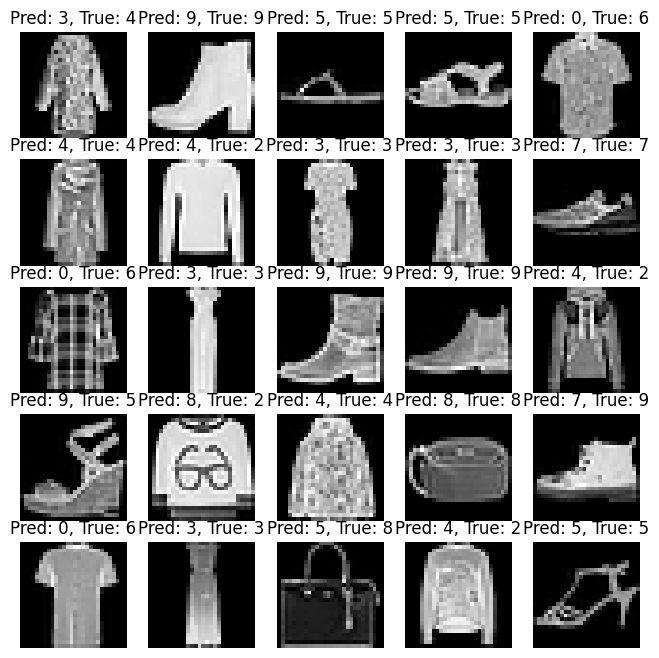

In [ ]:
# Plot predictions vs true labels for the first 9 images
model.eval()
with torch.no_grad():
    # Grab a batch of test data
    images, labels = next(iter(test_loader))
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)

    # Plot the first 9 images with predictions and true labels
    plt.figure(figsize=(8, 8))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f"Pred: {predicted[i].item()}, True: {labels[i].item()}")
        plt.axis('off')
    plt.show()



---



**Step5**: Train with SGD and Momentum

* set number of epochs to 10
* `lr` = 0.01
* momentum = 0.9

In [ ]:
# Set number of epochs
num_epochs = 10

# Initialize the optimizer
optimizer_momentum = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Store loss for each epoch
epoch_losses = []

# Train the model for num_epochs
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        optimizer_momentum.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer_momentum.step()

        running_loss += loss.item()

    # Calculate average loss for the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# Step 2: Calculate accuracy after all epochs
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy with Momentum optimizer: {accuracy:.2f}%")


Epoch 1/10, Loss: 1.7713
Epoch 2/10, Loss: 1.7470
Epoch 3/10, Loss: 1.7342
Epoch 4/10, Loss: 1.7130
Epoch 5/10, Loss: 1.6671
Epoch 6/10, Loss: 1.6575
Epoch 7/10, Loss: 1.6522
Epoch 8/10, Loss: 1.6468
Epoch 9/10, Loss: 1.6483
Epoch 10/10, Loss: 1.6440
Accuracy with Momentum optimizer: 80.50%


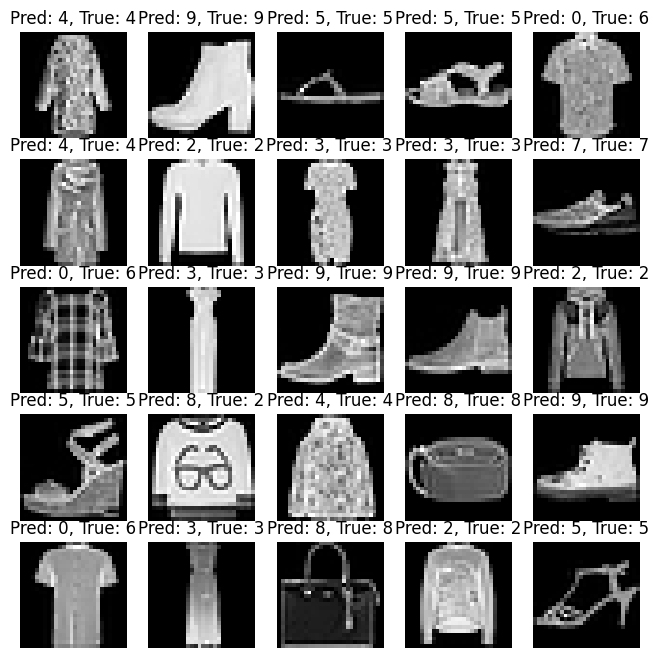

In [ ]:
# Plot predictions vs true labels for the first 9 images
model.eval()
with torch.no_grad():
    # Grab a batch of test data
    images, labels = next(iter(test_loader))
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)

    # Plot the first 9 images with predictions and true labels
    plt.figure(figsize=(8, 8))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f"Pred: {predicted[i].item()}, True: {labels[i].item()}")
        plt.axis('off')
    plt.show()



---



**Step6**: Training with RMS Prop

* set number of epochs to 10
* `lr` = 0.001
* alpha = 0.9

In [ ]:
# Set number of epochs
num_epochs = 10

# Initialize the optimizer and loss function
optimizer_rms = optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9)

# Store loss for each epoch
epoch_losses = []

# Train the model for num_epochs
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        optimizer_rms.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer_rms.step()

        running_loss += loss.item()

    # Calculate average loss for the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# Step 2: Calculate accuracy after all epochs
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy with RMS optimizer: {accuracy:.2f}%")


Epoch 1/10, Loss: 1.6803
Epoch 2/10, Loss: 1.6688
Epoch 3/10, Loss: 1.6624
Epoch 4/10, Loss: 1.6609
Epoch 5/10, Loss: 1.6580
Epoch 6/10, Loss: 1.6502
Epoch 7/10, Loss: 1.6467
Epoch 8/10, Loss: 1.6497
Epoch 9/10, Loss: 1.6465
Epoch 10/10, Loss: 1.6416
Accuracy with RMS optimizer: 80.07%


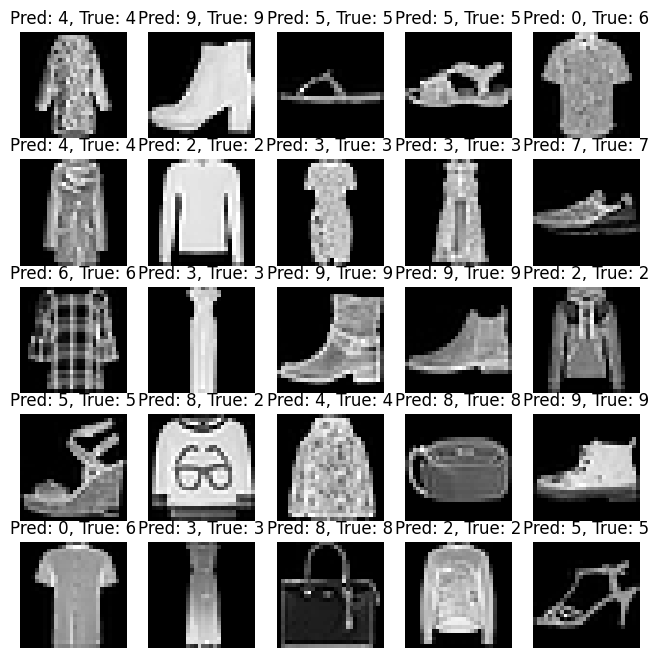

In [ ]:
# Plot predictions vs true labels for the first 9 images
model.eval()
with torch.no_grad():
    # Grab a batch of test data
    images, labels = next(iter(test_loader))
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)

    # Plot the first 9 images with predictions and true labels
    plt.figure(figsize=(8, 8))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f"Pred: {predicted[i].item()}, True: {labels[i].item()}")
        plt.axis('off')
    plt.show()



---



**BONUS**: Train with Adam Optimizer and compare the accuracy